In [34]:
from keras.datasets import mnist
import numpy as np
from matplotlib import pyplot
import random

In [ ]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

#printing the shapes of the vectors 
print('Shapes of the mnist data:')
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

# TODO: will need to process the data to one-encode train_y

Shapes of the mnist data:
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)
5
0
4
1
9
2
1
3
1
4


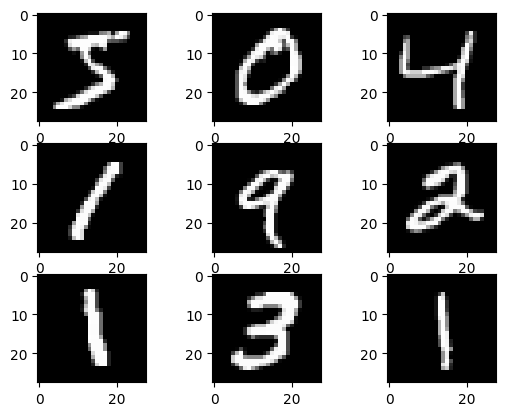

In [ ]:
for i in range(9):
    # some sus syntax -> 330 + 1 + i means
    # 3x3 grid. (+1 + i) is the position in the grid
    # ...SUS :/
    # it's the same as pyplot.subplot(3, 3, i+1)
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(train_X[i], cmap=pyplot.get_cmap('gray'))


In [47]:
class Network:
    """
    Configurable neural net

    Attributes:
        num_layers: number of layers the net has
        sizes: list of neurons at each layer
        biases: list of bias vectors, where each bias vector
            holds the biases for a given layer. input layer
            has no bias on the neurons obvs
        weights: list of weights matrices, where each weight
            matrix holds the matrix of weights for a given layer.
            matrix size is N x M where:
            N - number of neurons at current layer (l)
            M - number of neurons at next layer (l + 1)            
    """
    def __init__(self, sizes):
        """
        Construct network of layers and rand init for weights & biases

        Args:
            sizes: list holds the number of neurons
                at each layer
       """
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(b, 1) for b in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for (x,y) in zip(sizes[:-1], sizes[1:])]

    def metadata(self):
        """
        Prints the metadata of this class
        """
        print('=============\nNetwork metadata:')
        print('=============')
        print(f'Layers: {self.num_layers}')
        print(f'Sizes: {self.sizes}')
        
        print(f'Biases: {[np.asarray(b).shape for b in self.biases]}')
        print(f'Weights: {[np.asarray(w).shape for w in self.weights]}')

    def feedforward(self, a):
        """
        Does a forward propagation and computes the activations in
        the output layer of the network

        Args:
            a: the activations from the previous layer, if first
            hidden layer then a is just the input to the network
        """
        for (w, b) in zip(self.weights, self.biases):
            a = sigmoid(np.dot(w, a) + b)
        return a

    def SGD(self,
            training_data, 
            epochs,
            mini_batch_size,
            lr,
            test_data = None):
        """
        stoch grad desc
        for each epoch, for each mini batch in a batch:
        we wanna compute the following for each mini batch:
        dc/dw, dc/db, error for the output and hidden layers
        if using minibatches we'll just accumulate gradients
        throughout the epoch, i think at the end we can just
        perform an avg of the gradient accum / num of mini batches
        need to use extra storage for this
        mini batch should be shuffled too for each epoch

        Compute the stochastic gradient descent

        Args:
            training_data: list of tuples holding [(x1,y1), ..., (xN,yN)]
                where x is a vector of input features e.g. pixels of img
                where y is a vector of one-hot encoded 10 classification labels
            epochs: number of epochs during training
            mini_batch_size: number of training examples in a given mini batch
            lr: float for the learning rate
            test_data: optional, will be list of tuples, same as training_data
        """
        for epoch in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k + mini_batch_size]
                for k in range(0, len(training_data), mini_batch_size)
            ]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, lr);

            if test_data:
                print(f'Epoch {epoch}: {self.evaluate(test_data)} / {len(test_data)} : {self.evaluate(test_data) * 100 / len(test_data)}%')
            else:
                print(f'Epoch {epoch} complete')  

    def update_mini_batch(self, mini_batch, lr):
        """
        for a given mini batch which should have x,y where:
        x - training data
        y - label
        compute the grad of w,b then accumulate this until
        the entire batch has been processed
        after the entire backwards pass just update the weights
        and biases with the avg'd accumulated grads
        """
        grad_w = [np.zeros(w.shape) for w in self.weights]
        grad_b = [np.zeros(b.shape) for b in self.biases]
        for (x, y) in mini_batch:
            delta_w, delta_b = self.backprop(x, y)
            grad_w = [grads + deltas for grads, deltas in zip(grad_w, delta_w)]
            grad_b = [grads + deltas for grads, deltas in zip(grad_b, delta_b)]
        
        self.weights = [weights - ((lr * grads) / len(mini_batch))
                        for weights, grads in zip(self.weights, grad_w)]
        self.biases = [biases - ((lr * grads) / len(mini_batch))
                       for biases, grads in zip(self.biases, grad_b)]

    def backprop(self, x, y):
        """
        do the backwards pass, init za zero'd bias and weights matrix
        compute output delta
        compute delta at each layer
        return the biases and weights grads for each network layer
        """
        grad_w = [np.zeros(w.shape) for w in self.weights]
        grad_b = [np.zeros(b.shape) for b in self.biases]

        # keep a ref to activations and weighted inputs because
        # layers need other layers' as, zs
        activation = x
        activations = [x]
        zs = []
        
        # compute activations for the network
        for w, b in zip(self.weights, self.biases):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        delta = self.cost_derivative(activations[-1], y) * sigmoid_derivative(zs[-1])
        grad_b[-1] = delta
        grad_w[-1] = np.dot(delta, activations[-2].transpose())

        for l in range(2, self.num_layers):
            z = zs[-l]
            a_primed = sigmoid_derivative(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * a_primed
            grad_w[-l] = np.dot(delta, activations[-l-1].transpose())
            grad_b[-l] = delta

        return (grad_w, grad_b)
    
    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)


    def cost_derivative(self, output_activations, y):
        """
        for now probs just the MSE
        deriv of MSE implemented (simple)
        """
        return output_activations - y

# Misc functions - probs can be part of a utils/math/linalg lib
def sigmoid(x):
    """
    impl sigmoid activation algo
    """
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_derivative(x):
    """
    impl sigmoid derivative
    """
    return sigmoid(x) * (1 - sigmoid(x))


In [38]:
def vectorized_result(j):
    """Convert digit (0-9) to one-hot encoded column vector"""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

def load_data_wrapper():
    """
    Load MNIST data from Keras and format for Network class.

    Returns:
        training_data: list of (x, y) tuples where:
            x: (784, 1) column vector of pixel values
            y: (10, 1) one-hot encoded column vector
        test_data: list of (x, y) tuples where:
            x: (784, 1) column vector of pixel values
            y: integer label (0-9)
    """
    (train_X, train_y), (test_X, test_y) = mnist.load_data()

    # Training data: reshape images to (784,1) and one-hot encode labels
    training_inputs = [np.reshape(x, (784, 1)) / 255.0 for x in train_X]
    training_results = [vectorized_result(y) for y in train_y]
    training_data = list(zip(training_inputs, training_results))

    # Test data: reshape images to (784,1), keep labels as integers
    test_inputs = [np.reshape(x, (784, 1)) / 255.0 for x in test_X]
    test_data = list(zip(test_inputs, test_y))

    return (training_data, test_data)

# Load and validate data
training_data, test_data = load_data_wrapper()

print("Data shapes validation:")
print("=" * 50)
print(f"Training set size: {len(training_data)}")
print(f"Test set size: {len(test_data)}")
print()

# Check first training example
x_train, y_train = training_data[0]
print("Training data format:")
print(f"  Input (x) shape: {x_train.shape} (expected: (784, 1))")
print(f"  Label (y) shape: {y_train.shape} (expected: (10, 1))")
print(f"  Label (y) sample:\n{y_train.T}")
print()

# Check first test example
x_test, y_test = test_data[0]
print("Test data format:")
print(f"  Input (x) shape: {x_test.shape} (expected: (784, 1))")
print(f"  Label (y) type: {type(y_test)} (expected: int)")
print(f"  Label (y) value: {y_test}")
print("=" * 50)

Data shapes validation:
Training set size: 60000
Test set size: 10000

Training data format:
  Input (x) shape: (784, 1) (expected: (784, 1))
  Label (y) shape: (10, 1) (expected: (10, 1))
  Label (y) sample:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

Test data format:
  Input (x) shape: (784, 1) (expected: (784, 1))
  Label (y) type: <class 'numpy.uint8'> (expected: int)
  Label (y) value: 7


In [42]:
training_data, test_data = load_data_wrapper()

net = Network([784, 30, 10])
net.SGD(training_data,
        epochs=25,
        mini_batch_size=10,
        lr=3.0,
        test_data=test_data)

Epoch 0: 0.9152
Epoch 1: 0.925
Epoch 2: 0.9323
Epoch 3: 0.939
Epoch 4: 0.9422
Epoch 5: 0.946
Epoch 6: 0.9456
Epoch 7: 0.9495
Epoch 8: 0.9485
Epoch 9: 0.9478
Epoch 10: 0.948
Epoch 11: 0.9496
Epoch 12: 0.9512
Epoch 13: 0.9525
Epoch 14: 0.9513
Epoch 15: 0.9548
Epoch 16: 0.9529
Epoch 17: 0.9535
Epoch 18: 0.9539
Epoch 19: 0.9515
Epoch 20: 0.9546
Epoch 21: 0.9534
Epoch 22: 0.9536
Epoch 23: 0.9529
Epoch 24: 0.9548


In [48]:
training_data, test_data = load_data_wrapper()

net = Network([784, 30, 10])
net.SGD(training_data,
        epochs=25,
        mini_batch_size=10,
        lr=3.0,
        test_data=test_data)

Epoch 0: 8381 / 10000 : 83.81%
Epoch 1: 9262 / 10000 : 92.62%
Epoch 2: 9376 / 10000 : 93.76%
Epoch 3: 9398 / 10000 : 93.98%
Epoch 4: 9420 / 10000 : 94.2%
Epoch 5: 9430 / 10000 : 94.3%
Epoch 6: 9448 / 10000 : 94.48%
Epoch 7: 9465 / 10000 : 94.65%
Epoch 8: 9487 / 10000 : 94.87%
Epoch 9: 9495 / 10000 : 94.95%
Epoch 10: 9517 / 10000 : 95.17%
Epoch 11: 9495 / 10000 : 94.95%
Epoch 12: 9510 / 10000 : 95.1%
Epoch 13: 9502 / 10000 : 95.02%
Epoch 14: 9545 / 10000 : 95.45%
Epoch 15: 9495 / 10000 : 94.95%
Epoch 16: 9535 / 10000 : 95.35%
Epoch 17: 9525 / 10000 : 95.25%
Epoch 18: 9487 / 10000 : 94.87%
Epoch 19: 9543 / 10000 : 95.43%
Epoch 20: 9530 / 10000 : 95.3%
Epoch 21: 9556 / 10000 : 95.56%
Epoch 22: 9530 / 10000 : 95.3%
Epoch 23: 9526 / 10000 : 95.26%
Epoch 24: 9536 / 10000 : 95.36%
